# Runtime UI

Martha Blatt and Mary Lynn Dekold

## Trial 1 - Same Protocol for Each Heater

## 1. Display Setpoints 

In [79]:
import pandas as pd
def protodisplay(ph1, hnum):
    # This function displays quantitative read out of setpoint values
    # ph1 is the name of the csv file and is an input
    # hnum is the heater number and is an input 
    
    counter = 0 # initializes counter 
    
    for i in range(len(ph1.tp)-1):
        pt1 = ph1.tp[i]
        pt2 = ph1.tp[i+1]
        pT1 = ph1.Tp[i]
        pT2 = ph1.Tp[i+1]
        
        # final extension temperature 
        if pT2 > pT1: 
            fextT = pT2
        
        # initial denaturation temperature and time 
        # heating rate
        if pT2-pT1 > 60:
            idenatT = pT2
            hr = (pT2 - pT1) / (pt2 - pt1)
            pTmodela = pT1
        
        # final extension time 
        if pT2 == pT1:
            fextt = pt2 - pt1
        
        # initial denaturation time 
        if pT2 == idenatT:
            idenatt = pt2 - pt1
            
        # denaturation temperature and time for cycle
        if pT2 == pT1 and pT2 > 80:
            denatT = pT2
            if pT2 == pT1:
                denatt = pt2 - pt1

        # extension temperature and time for cycle 
        if pT2 == pT1 and pT2 > 68 and pT2<72 and counter <2:
            extT = pT2
            if pT2 == pT1:
                extt = pt2 - pt1
                counter += 1.5
                
        # anneal tempearture and time for cycle
        # cycle counter
        if pT2 == pT1 and pT2 < 70:
            annealT = pT2
            if pT2 == pT1:
                annealt = pt2 - pt1  
                
        # adjust initial denaturation time if needed
        if pT2 == idenatT and counter > 1 and idenatt != denatt:
            idenatt = idenatt - denatt
    
    # cooling rate
    phlen = len(ph1.tp)
    cr = (fextT - pTmodela) / (ph1.tp[phlen-1] - ph1.tp[phlen-2])

    # print results
    print('HEATER', hnum, ': ')
    print('Number of Cycles:                ', counter)
    print('Heating Rate:                    ', round(hr,3))
    print('Cooling Rate:                    ', round(cr,3))
    print('')
    print('Initial Denaturation Temperature: ', round(idenatT, 3), 'Celsius')
    print('Initial Denaturation Time:       ', idenatt, 's')
    print('')
    print('Denaturation Temperature:        ', denatT, 'Celsius')
    print('Denaturation Time:               ', denatt, 's')
    print('')
    print('Anneal Tempearture:              ', annealT, 'Celsius')
    print('Anneal Time:                     ', annealt, 's')
    print('')
    print('Extension Tempearture:           ', extT, 'Celsius')
    print('Extension Time:                  ', round(extt, 3), 's')
    print('')
    print('Final Extension Tempearture:     ', fextT, 'Celsius')
    print('Final Extension Time:            ', fextt, 's')
    print('')
    print('')
    return


In [38]:
# read in csv 
ph1 = pd.read_csv(r'pcr/pcr1.csv')
ph2 = pd.read_csv(r'pcr/pcr2.csv')

# readout setpoints 
protodisplay(ph1, 1)
protodisplay(ph2, 2)

HEATER 1 : 
Number of Cycles:                 3
Heating Rate:                     0.23
Cooling Rate:                     0.24

Initial Denaturation Temperature:  94.0 Celsius
Initial Denaturation Time:        100.0 s

Denaturation Temperature:         94.0 Celsius
Denaturation Time:                100.0 s

Anneal Tempearture:               64.0 Celsius
Anneal Time:                      100.0 s

Extension Tempearture:            70.0 Celsius
Extension Time:                   100.0 s

Final Extension Tempearture:      70.0 Celsius
Final Extension Time:             30.0 s


HEATER 2 : 
Number of Cycles:                 3
Heating Rate:                     0.22
Cooling Rate:                     0.22

Initial Denaturation Temperature:  94.0 Celsius
Initial Denaturation Time:        100.0 s

Denaturation Temperature:         94.0 Celsius
Denaturation Time:                100.0 s

Anneal Tempearture:               64.0 Celsius
Anneal Time:                      100.0 s

Extension Tempearture:  

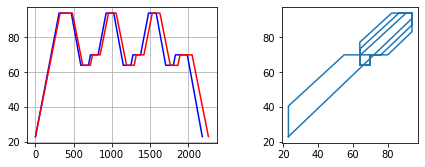

In [39]:
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def get_data(file1, file2):
    # This function takes in the csv files and qualitatively shows set point values 
    # numpy arrays of set point values are made 
    
    # plot
    fig, ax = plt.subplots(1,2, figsize=(7.5,2.5))
    if file1:
        df1 = pd.read_csv(file1)
        ax[0].plot(df1['tp'], df1['Tp'], 'b')
    if file2:
        df2 = pd.read_csv(file2)
        ax[0].plot(df2['tp'], df2['Tp'], 'r')
    ax[0].grid(True)
    
    # use np.interp to interpolate between user specified setpoint vlaues 
    if file1 and file2:
        tmax = max(df1['tp'].max(), df2['tp'].max())
        t = np.linspace(0, tmax, int(tmax+1))
        SP1 = lambda t: np.interp(t, df1['tp'].to_numpy(), df1['Tp'].to_numpy())
        SP2 = lambda t: np.interp(t, df2['tp'].to_numpy(), df2['Tp'].to_numpy())
        ax[1].plot(SP1(t), SP2(t))
        ax[1].axis('square')
        return SP1, SP2

# define set point arrays for each heater
SP1, SP2 = get_data('pcr/pcr1.csv', 'pcr/pcr2.csv')

## 2. Model Predictive Control (MPC)

In [21]:
def mpc(t_horizon, dt): 
    # MPC control algorithm is implemented in code below

    # initialize time horizon for MPC
    K = int(t_horizon/dt)
    Kb = 1 
    
    # 2 State Model - values from model identification 
    # parameters
    Ua = 0.0212858 # W/deg C
    Ub = 0.01351099 # W/deg C
    Cp_H = 5.14761395 # J/deg C
    # model equations
    A = np.array([[-(Ua+Ub)/Cp_H, Ub/Cp_H], [Ub/Cp_H, -(Ua+Ub)/Cp_H]])
    B = np.array([[1/(Cp_H), 0], [0, 1/(Cp_H)]])
    C = np.array([[1, 0], [0, 1]])
    D = np.array([[0, 0], [0, 0]])

    
    # physical constraints
    umax = 3.3 # W
    umin = 0 # W
    ymin = 0 # deviation variable
    ymax = 100-Ta # deviation variable

    u = [0, 0]

    # discrete time
    Ad = np.eye(2) + dt*A
    Bd = dt*B
    
    while True:
        y, t = yield u # use generator to update values
        
        # initialize time and make time horizon
        tp = np.linspace(t, t + dt*K, K+1)
        
        # initialize predicted variables
        up = cp.Variable((K+1, 2))
        xp = cp.Variable((K+1, 2))
        yp = cp.Variable((K+1, 2))
        
        # objective function 
        objective = cp.Minimize(sum([cp.norm(np.array([SP1(tp[k])-Ta, SP2(tp[k])-Ta])- yp[k])**2 for k in range(0, K)]))
        
        # constraints 
        constraints = [xp[0] == y] # initial xp values are experimental tempeartures 
        constraints += [up >= umin] + [up <= umax]
        constraints += [xp[k+1] == Ad @ xp[k] + Bd @ up[k] for k in range(K)] # solve 2 state heater model 
        constraints += [yp[k] == C @ xp[k] + D @ up[k] for k in range(K+1)]
        constraints += [yp >= ymin] + [yp <= ymax] # watch out for this!!!

        prob = cp.Problem(objective, constraints) # solves problem 
        prob.solve()
        u = up.value[0,:]

## 3. Simulation

In [82]:
%matplotlib inline

from IPython.display import display
import ipywidgets as widgets
import tclab
import threading
import datetime

df1 = pd.read_csv('pcr/pcr1.csv')
df2 = pd.read_csv('pcr/pcr2.csv')
tmax = max(df1['tp'].max(), df2['tp'].max())
tmax = .3*tmax + tmax
dt = 2
thor = 200
Ta = 20

TCLab = tclab.setup(connected=False, speedup=5)

def work(output, stop):
    with output:
        with TCLab() as lab:
            # pre-run
            lab.P1 = 255
            lab.P2 = 255
            sources = [
                ('T1', lambda: lab.T1),
                ('T2', lambda: lab.T2),
                ('U1', lambda: lab.U1),
                ('U2', lambda: lab.U2),
                ('SP1', lambda: SP1(t)), 
                ('SP2', lambda: SP2(t)), 
                ('SP1-T1', lambda: SP1(t)-lab.T1), 
                ('SP2-T2', lambda: SP2(t)-lab.T2), 
            ]
            h = tclab.Historian(sources)
            p = tclab.Plotter(h, tmax, layout=(('T1', 'SP1'), ('T2', 'SP2'),('U1','U2'), ('SP1-T1','SP2-T2')))
            control = mpc(thor, dt)
            control.send(None)

            # run
            tstart = time.time()
            for t in tclab.clock(tmax, dt):
                T1 = lab.T1                           # measure the sensor temperature
                T2 = lab.T2
                ynew = [T1-Ta, T2-Ta]
                Q1_mpc, Q2_mpc = control.send([ynew, t]) 
                lab.U1 = max(0, min(100, (100*Q1_mpc)/lab.P1/0.013))
                lab.U2 = max(0, min(100, (100*Q2_mpc)/lab.P1/0.013))
                p.update(t)
                # calculate time
                tfin = time.time()
                trun = tfin-tstart
                if T1 < 30 and T2 < 30 and trun>60:
                    t1run = trun
                    print('Run Complete.')
                    print('The temperature of both heaters is less than 30 degrees Celsius')
                    print('Run Time:', t1run/60, 'minutes')
                    break
                if stop.value:
                    print('Run interrupted.')
                    print('Run Time:', trun/60, 'minutes')
                    break 
            #post-run
            fname = datetime.datetime.now().strftime("data_%Y%M%dT%H%M%S.csv")
            h.to_csv(fname)
            print("Data saved to", fname)

# widgets
start = widgets.Button(description="Start", button_style="success")
stop = widgets.Button(description="Stop", button_style="")
output = widgets.Output(layout={'height': '450px'})

# thread
thread = threading.Thread(target=work, args=(output, stop))

# actions
def start_button_clicked(b):
    stop.value = False
    start.button_style = ""
    stop.button_style="success"
    thread.start()
start.on_click(start_button_clicked)

def stop_button_clicked(b):
    stop.value = True
    stop.button_style = ""
    thread.join()
stop.on_click(stop_button_clicked)

# START THINGS UP
display(widgets.HBox([start, stop]))
display(output)

Output(layout=Layout(height='450px'))

## 4. Experiment 

In [23]:
%matplotlib inline

from IPython.display import display
import ipywidgets as widgets
import tclab
import threading
import datetime

df1 = pd.read_csv('pcr/pcr1.csv')
df2 = pd.read_csv('pcr/pcr2.csv')
tmax = max(df1['tp'].max(), df2['tp'].max())
tmax = .3*tmax + tmax
dt = 2
thor = 200
Ta = 20

TCLab = tclab.setup(connected=True)

def work(output, stop):
    with output:
        with TCLab() as lab:
            # pre-run
            lab.P1 = 255
            lab.P2 = 255
            sources = [
                ('T1', lambda: lab.T1),
                ('T2', lambda: lab.T2),
                ('U1', lambda: lab.U1),
                ('U2', lambda: lab.U2),
                ('SP1', lambda: SP1(t)), 
                ('SP2', lambda: SP2(t)), 
                ('SP1-T1', lambda: SP1(t)-lab.T1), 
                ('SP2-T2', lambda: SP2(t)-lab.T2), 
            ]
            h = tclab.Historian(sources)
            p = tclab.Plotter(h, tmax, layout=(('T1', 'SP1'), ('T2', 'SP2'),('U1','U2'), ('SP1-T1','SP2-T2')))
            control = mpc(thor, dt)
            control.send(None)

            # run
            tstart = time.time()
            for t in tclab.clock(tmax, dt):
                T1 = lab.T1                           # measure the sensor temperature
                T2 = lab.T2
                ynew = [T1-Ta, T2-Ta]
                Q1_mpc, Q2_mpc = control.send([ynew, t]) 
                lab.U1 = max(0, min(100, (100*Q1_mpc)/lab.P1/0.013))
                lab.U2 = max(0, min(100, (100*Q2_mpc)/lab.P1/0.013))
                p.update(t)
                # calculate time
                tfin = time.time()
                trun = tfin-tstart
                if T1 < 30 and T2 < 30 and trun>60:
                    t1run = trun
                    print('Run Complete.')
                    print('The temperature of both heaters is less than 30 degrees Celsius')
                    print('Run Time:', t1run/60, 'minutes')
                    break
                if stop.value:
                    print('Run interrupted.')
                    print('Run Time:', trun/60, 'minutes')
                    break 
            #post-run
            fname = datetime.datetime.now().strftime("data_%Y%M%dT%H%M%S.csv")
            h.to_csv(fname)
            print("Data saved to", fname)

# widgets
start = widgets.Button(description="Start", button_style="success")
stop = widgets.Button(description="Stop", button_style="")
output = widgets.Output(layout={'height': '450px'})

# thread
thread = threading.Thread(target=work, args=(output, stop))

# actions
def start_button_clicked(b):
    stop.value = False
    start.button_style = ""
    stop.button_style="success"
    thread.start()
start.on_click(start_button_clicked)

def stop_button_clicked(b):
    stop.value = True
    stop.button_style = ""
    thread.join()
stop.on_click(stop_button_clicked)

# START THINGS UP
display(widgets.HBox([start, stop]))
display(output)

Output(layout=Layout(height='450px'))

## Trial 2 - Different Protocol for Each Heater

## 1. Display Setpoints

In [80]:
# read in csv 
ph1 = pd.read_csv(r'pcr/pcr01.csv')
ph2 = pd.read_csv(r'pcr/pcr02.csv')

# readout setpoints 
protodisplay(ph1, 1)
protodisplay(ph2, 2)

HEATER 1 : 
Number of Cycles:                 3.0
Heating Rate:                     0.22
Cooling Rate:                     0.22

Initial Denaturation Temperature:  94.0 Celsius
Initial Denaturation Time:        100.0 s

Denaturation Temperature:         94.0 Celsius
Denaturation Time:                100.0 s

Anneal Tempearture:               64.0 Celsius
Anneal Time:                      100.0 s

Extension Tempearture:            70.0 Celsius
Extension Time:                   100.0 s

Final Extension Tempearture:      70.0 Celsius
Final Extension Time:             30.0 s


HEATER 2 : 
Number of Cycles:                 3.0
Heating Rate:                     0.22
Cooling Rate:                     0.22

Initial Denaturation Temperature:  92.0 Celsius
Initial Denaturation Time:        80.0 s

Denaturation Temperature:         92.0 Celsius
Denaturation Time:                80.0 s

Anneal Tempearture:               69.0 Celsius
Anneal Time:                      30.0 s

Extension Tempearture: 

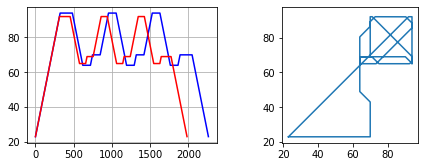

In [35]:
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def get_data(file1, file2):
    # This function takes in the csv files and qualitatively shows set point values 
    # numpy arrays of set point values are made 
    
    # plot
    fig, ax = plt.subplots(1,2, figsize=(7.5,2.5))
    if file1:
        df1 = pd.read_csv(file1)
        ax[0].plot(df1['tp'], df1['Tp'], 'b')
    if file2:
        df2 = pd.read_csv(file2)
        ax[0].plot(df2['tp'], df2['Tp'], 'r')
    ax[0].grid(True)
    
    # use np.interp to interpolate between user specified setpoint vlaues 
    if file1 and file2:
        tmax = max(df1['tp'].max(), df2['tp'].max())
        t = np.linspace(0, tmax, int(tmax+1))
        SP1 = lambda t: np.interp(t, df1['tp'].to_numpy(), df1['Tp'].to_numpy())
        SP2 = lambda t: np.interp(t, df2['tp'].to_numpy(), df2['Tp'].to_numpy())
        ax[1].plot(SP1(t), SP2(t))
        ax[1].axis('square')
        return SP1, SP2

# define set point arrays for each heater
SP1, SP2 = get_data('pcr/pcr01.csv', 'pcr/pcr02.csv')

## 2. Experiment

In [36]:
%matplotlib inline

from IPython.display import display
import ipywidgets as widgets
import tclab
import threading
import datetime

df1 = pd.read_csv('pcr/pcr1.csv')
df2 = pd.read_csv('pcr/pcr2.csv')
tmax = max(df1['tp'].max(), df2['tp'].max())
tmax = .3*tmax + tmax
dt = 2
thor = 200
Ta = 20

TCLab = tclab.setup(connected=True)

def work(output, stop):
    with output:
        with TCLab() as lab:
            # pre-run
            lab.P1 = 255
            lab.P2 = 255
            sources = [
                ('T1', lambda: lab.T1),
                ('T2', lambda: lab.T2),
                ('U1', lambda: lab.U1),
                ('U2', lambda: lab.U2),
                ('SP1', lambda: SP1(t)), 
                ('SP2', lambda: SP2(t)), 
                ('SP1-T1', lambda: SP1(t)-lab.T1), 
                ('SP2-T2', lambda: SP2(t)-lab.T2), 
            ]
            h = tclab.Historian(sources)
            p = tclab.Plotter(h, tmax, layout=(('T1', 'SP1'), ('T2', 'SP2'),('U1','U2'), ('SP1-T1','SP2-T2')))
            control = mpc(thor, dt)
            control.send(None)

            # run
            tstart = time.time()
            for t in tclab.clock(tmax, dt):
                T1 = lab.T1                           # measure the sensor temperature
                T2 = lab.T2
                ynew = [T1-Ta, T2-Ta]
                Q1_mpc, Q2_mpc = control.send([ynew, t]) 
                lab.U1 = max(0, min(100, (100*Q1_mpc)/lab.P1/0.013))
                lab.U2 = max(0, min(100, (100*Q2_mpc)/lab.P1/0.013))
                p.update(t)
                # calculate time
                tfin = time.time()
                trun = tfin-tstart
                if T1 < 30 and T2 < 30 and trun>60:
                    t1run = trun
                    print('Run Complete.')
                    print('The temperature of both heaters is less than 30 degrees Celsius')
                    print('Run Time:', t1run/60, 'minutes')
                    break
                if stop.value:
                    print('Run interrupted.')
                    print('Run Time:', trun/60, 'minutes')
                    break 
            #post-run
            fname = datetime.datetime.now().strftime("data_%Y%M%dT%H%M%S.csv")
            h.to_csv(fname)
            print("Data saved to", fname)

# widgets
start = widgets.Button(description="Start", button_style="success")
stop = widgets.Button(description="Stop", button_style="")
output = widgets.Output(layout={'height': '450px'})

# thread
thread = threading.Thread(target=work, args=(output, stop))

# actions
def start_button_clicked(b):
    stop.value = False
    start.button_style = ""
    stop.button_style="success"
    thread.start()
start.on_click(start_button_clicked)

def stop_button_clicked(b):
    stop.value = True
    stop.button_style = ""
    thread.join()
stop.on_click(stop_button_clicked)

# START THINGS UP
display(widgets.HBox([start, stop]))
display(output)

Output(layout=Layout(height='450px'))